# Malware Family Classification using API Call Sequences

> Author: Tien Ly  
> CS 271: Topics in Machine Learning - Spring 2025 at San Jose State University

**Project Overview**  
This notebook presents an approach to malware classification by analyzing the sequence of API calls made by malicious software. It serves as the entry point in a multi-notebook series on malware classification.

**Project Goals**
- Process and explore API call sequence data from various malware families  
- Convert API call sequences into meaningful embeddings using **Word2Vec** and **BERT**  
- Train and evaluate several machine learning models for malware family classification:
  - **Random Forest**
  - **XGBoost**
  - **CNN** (in separate notebooks: `malware-word2vec-cnn.ipynb` and `malware-bert-cnn.ipynb`)
- Compare the performance of different embedding and classifier combinations and perform hyperparameter tuning for the top 2 performing models (`malware-summary.ipynb`)

## Section 1: Data Loading and Exploration

### 1.1 Read Data

In [41]:
# %pip install numpy pandas matplotlib seaborn scikit-learn xgboost gensim transformers torch ipykernel ipywidgets

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [2]:
def set_seed(seed_value=42):
    """ Set random seeds for reproducibility """

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [3]:
# Load malware API call files into a DataFrame
base_path = 'data_family/AllFiles_CleanLogAPI'
malware_families = os.listdir(base_path)
malware_families.sort()

print(f'Malware families: {malware_families}')

Malware families: ['adload', 'bancos', 'onlinegames', 'vbinject', 'vundo', 'winwebsec', 'zwangi']


In [4]:
files = []

# Process each family subfolder
for family in malware_families:
  family_path = os.path.join(base_path, family)
  
  # Process each file in the family folder
  for file in os.listdir(family_path):
    with open(os.path.join(family_path, file)) as f:
      # Read all lines and join them with whitespace to form a single string
      api_calls = ' '.join([line.strip() for line in f if line.strip()])
      files.append({'filename': file, 'family': family,'api_calls': api_calls})

In [5]:
malware = pd.DataFrame(files)
display(malware)

,filename,family,api_calls
0,VirusShare_0e3d809f55f9df8d1e2f94f5eec6178e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...
1,VirusShare_0d751458aa11f75fd36bf36834ca0c0b_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...
2,VirusShare_0d3c513d5429e28bd87b0fe9599218c0_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...
3,VirusShare_0ca6b5d97cd7d172cc84cfb5aa42e314_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...
4,VirusShare_0b854d98c7d576ac20f5897cfa24c390_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...
...,...,...,...
487,VirusShare_104a9541d89aa249fd912f61aaa51eb5_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...
488,VirusShare_0f82597a5fd4790186fd6d3d7d7a6046_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...
489,VirusShare_0c74df20677e9083cc727b0eec0c9f0d_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...
490,VirusShare_02b8abad471036589e86b8b94d98a345_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...


### 1.2 Exploratory Data Analysis

In [6]:
malware.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   492 non-null    object
 1   family     492 non-null    object
 2   api_calls  492 non-null    object
dtypes: object(3)
memory usage: 11.7+ KB


In [7]:
print('Missing values per column:')
print(malware.isnull().sum())

Missing values per column:
filename     0
family       0
api_calls    0
dtype: int64


In [8]:
print(f'Total samples: {len(malware)}\n')
print('Samples per family:')
print(malware['family'].value_counts())

Total samples: 492

Samples per family:
family
bancos         71
vundo          71
adload         70
onlinegames    70
vbinject       70
winwebsec      70
zwangi         70
Name: count, dtype: int64


In [ ]:
# Expand the API calls into separate rows
exploded_malware = malware.assign(api_call=malware['api_calls'].str.split()).explode('api_call')
exploded_malware.head()

,filename,family,api_calls,api_call
0,VirusShare_0e3d809f55f9df8d1e2f94f5eec6178e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,VirtualAllocEx
0,VirusShare_0e3d809f55f9df8d1e2f94f5eec6178e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,QuerySystemInformation
0,VirusShare_0e3d809f55f9df8d1e2f94f5eec6178e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,QuerySystemInformation
0,VirusShare_0e3d809f55f9df8d1e2f94f5eec6178e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,QueryProcessInformation
0,VirusShare_0e3d809f55f9df8d1e2f94f5eec6178e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,CreateThread


In [21]:
print(f"Number of unique API calls: {exploded_malware['api_call'].nunique()}")

print("\nTop 10 most common API calls:")
print(exploded_malware['api_call'].value_counts().head(10))

print("\nUnique calls by family:")
print(exploded_malware.groupby('family')['api_call'].nunique())

Number of unique API calls: 79

Top 10 most common API calls:
api_call
VirtualAllocEx             69421
LdrFindEntryForAddress     12952
lstrcmpi                   12829
OpenProcess                10034
ResumeThread                9322
QueryProcessInformation     8348
GetModuleHandle             4532
QuerySystemInformation      4477
WriteProcessMemory          4269
GetProcessImageFileName     3705
Name: count, dtype: int64

Unique calls by family:
family
adload         39
bancos         67
onlinegames    57
vbinject       54
vundo          44
winwebsec      47
zwangi         38
Name: api_call, dtype: int64


### 1.3 Data Preprocessing

In [50]:
# Encode family labels
label_encoder = LabelEncoder() 
malware['family_encoded'] = label_encoder.fit_transform(malware['family'])
display(malware)

,filename,family,api_calls,family_encoded
0,VirusShare_000e2f2b46fe9a883f550a2c493bc86e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
1,VirusShare_00e7a6c7cedd158560fdf691e2bd86c8_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
2,VirusShare_0191bf41bdbd64cc2a789824038b136f_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
3,VirusShare_019c795a6bedb2aae2392590dc35eab1_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
4,VirusShare_0239ea751e7de5ea1cb0c463e924c469_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0
...,...,...,...,...
487,VirusShare_ee8abd8831806a06a85e8821db773277_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
488,VirusShare_f2b606c3319af4d2e99d308520f2b956_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
489,VirusShare_f30c6a1331242ca842337334d9d251bc_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6
490,VirusShare_f316af76d837f5444d3ff1bd03b76409_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6


In [51]:
# Save dataframe to Pickle file (for later use)
malware.to_pickle('malware.pkl')

# malware = pd.read_pickle('malware.pkl')
# display(malware)

## Section 2: Word Embeddings

### 2.1 Word2Vec

In [52]:
# Split API calls into tokens for Word2Vec
corpus = [file.split() for file in malware['api_calls']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1)
print(w2v_model)

Word2Vec<vocab=79, vector_size=100, alpha=0.025>


In [53]:
# Function to create average Word2Vec embeddings for each sample
def avg_word2vec(api_calls, model, vector_size):
    """
    Converts a sequence of API calls to a fixed-length vector by averaging the word embeddings of individual API calls

    Args:
        api_calls (str): Space-separated API call sequence
        model (Word2Vec): Trained Word2Vec model
        vector_size (int): Size of the embedding vectors
        
    Returns:
        numpy.ndarray: Average embedding vector of dimension 'vector_size'
    """
    avg_vec = np.zeros(vector_size)
    count = 0

    for call in api_calls.split():
        if call in model.wv:
            avg_vec += model.wv[call]
            count += 1

    if count > 0:
        avg_vec /= count

    return avg_vec

# Create embeddings for each sample
malware['w2v_embedding'] = malware['api_calls'].apply(
    lambda api_calls: avg_word2vec(api_calls, w2v_model, w2v_model.vector_size)
)

display(malware)

,filename,family,api_calls,family_encoded,w2v_embedding
0,VirusShare_000e2f2b46fe9a883f550a2c493bc86e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.24319828590456427, 0.4095204386687955, 0.07..."
1,VirusShare_00e7a6c7cedd158560fdf691e2bd86c8_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.3192994119176133, 0.3126627394195759, 0.107..."
2,VirusShare_0191bf41bdbd64cc2a789824038b136f_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.35232870802807975, 0.3023313647398437, 0.09..."
3,VirusShare_019c795a6bedb2aae2392590dc35eab1_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.21419722015776163, 0.4685576191910033, 0.07..."
4,VirusShare_0239ea751e7de5ea1cb0c463e924c469_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.2497971701846158, 0.44478531367287544, 0.06..."
...,...,...,...,...,...
487,VirusShare_ee8abd8831806a06a85e8821db773277_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.0765549134137521, 0.5077977184251578, 0.116..."
488,VirusShare_f2b606c3319af4d2e99d308520f2b956_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.07529302820632303, 0.4951471873300357, 0.15..."
489,VirusShare_f30c6a1331242ca842337334d9d251bc_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.036983148374461705, 0.49100753841589073, 0...."
490,VirusShare_f316af76d837f5444d3ff1bd03b76409_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.1370665498430262, 0.4759025306919137, 0.099..."


### 2.2 BERT (Bidirectional Encoder Representations from Transformers)

In [78]:
# Load pre-trained model tokenizer (vocabulary)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [56]:
# Tokenize the text
inputs = bert_tokenizer(malware['api_calls'].tolist(), return_tensors='pt',
                        padding=True, truncation=True, return_token_type_ids=False)

# Obtain the embeddings
with torch.no_grad():
    outputs = bert_model(**inputs)

In [57]:
# Get the embeddings for the [CLS] token
cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
# Add the BERT embeddings to dataframe
malware['bert_embedding'] = list(cls_embeddings)

display(malware)

,filename,family,api_calls,family_encoded,w2v_embedding,bert_embedding
0,VirusShare_000e2f2b46fe9a883f550a2c493bc86e_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.24319828590456427, 0.4095204386687955, 0.07...","[-0.7991742, 0.3438263, -0.10384858, -0.052014..."
1,VirusShare_00e7a6c7cedd158560fdf691e2bd86c8_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.3192994119176133, 0.3126627394195759, 0.107...","[-1.1525007, 0.30858508, -0.34731704, -0.10876..."
2,VirusShare_0191bf41bdbd64cc2a789824038b136f_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.35232870802807975, 0.3023313647398437, 0.09...","[-0.6354753, 0.208447, -0.12664948, 0.04532755..."
3,VirusShare_019c795a6bedb2aae2392590dc35eab1_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.21419722015776163, 0.4685576191910033, 0.07...","[-1.0789568, 0.3932857, -0.15799811, -0.234006..."
4,VirusShare_0239ea751e7de5ea1cb0c463e924c469_Cl...,adload,VirtualAllocEx QuerySystemInformation QuerySys...,0,"[0.2497971701846158, 0.44478531367287544, 0.06...","[-0.86646986, 0.37369943, -0.11611564, -0.0787..."
...,...,...,...,...,...,...
487,VirusShare_ee8abd8831806a06a85e8821db773277_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.0765549134137521, 0.5077977184251578, 0.116...","[-0.92455983, 0.44403458, -0.12784415, -0.0387..."
488,VirusShare_f2b606c3319af4d2e99d308520f2b956_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.07529302820632303, 0.4951471873300357, 0.15...","[-0.91322607, 0.42482898, -0.11122756, -0.0340..."
489,VirusShare_f30c6a1331242ca842337334d9d251bc_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.036983148374461705, 0.49100753841589073, 0....","[-0.9373291, 0.3942882, -0.099821806, -0.02300..."
490,VirusShare_f316af76d837f5444d3ff1bd03b76409_Cl...,zwangi,VirtualAllocEx QuerySystemInformation QuerySys...,6,"[0.1370665498430262, 0.4759025306919137, 0.099...","[-0.97449404, 0.5244397, -0.19178858, -0.28637..."


In [58]:
# Save dataframe to Pickle file (for later use)
malware.to_pickle('malware_embed.pkl')

# malware = pd.read_pickle('malware_embed.pkl')
# display(malware)

## Section 3: Model Training and Evaluation

### 3.1 Random Forest (RF)

#### 3.1.1 Word2Vec-RF

In [59]:
# Prepare Word2Vec features and target
X_word2vec = np.array(malware['w2v_embedding'].tolist())
y = malware['family_encoded']

# Split data into training and testing sets
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(
    X_word2vec, y, test_size=0.2, stratify=y, shuffle=True, random_state=42
)

In [60]:
# Train Word2Vec-RF classifier
rf_word2vec = RandomForestClassifier(n_estimators=100, random_state=42)
rf_word2vec.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(random_state=42)

In [61]:
# Make predictions
y_pred_rf_word2vec = rf_word2vec.predict(X_test_word2vec)
# Evaluate the model
print('Word2Vec + Random Forest Classifier:')
print(classification_report(y_test_word2vec, y_pred_rf_word2vec, target_names=malware_families))

Word2Vec + Random Forest Classifier:
              precision    recall  f1-score   support

      adload       1.00      1.00      1.00        14
      bancos       0.91      0.71      0.80        14
 onlinegames       0.73      0.79      0.76        14
    vbinject       0.75      0.86      0.80        14
       vundo       1.00      0.93      0.97        15
   winwebsec       0.79      0.79      0.79        14
      zwangi       0.93      1.00      0.97        14

    accuracy                           0.87        99
   macro avg       0.87      0.87      0.87        99
weighted avg       0.87      0.87      0.87        99



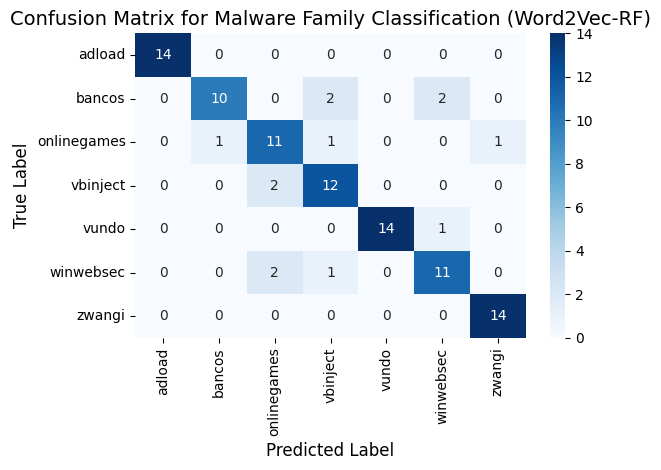

In [62]:
# Generate the confusion matrix
cm_rf_word2vec = confusion_matrix(y_test_word2vec, y_pred_rf_word2vec)
cm_rf_word2vec_df = pd.DataFrame(cm_rf_word2vec, index=label_encoder.classes_, columns=label_encoder.classes_)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_rf_word2vec_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (Word2Vec-RF)', fontsize=14)

plt.tight_layout()

In [ ]:
# Store accuracy results for different combination
accuracies = []

accuracies.append({
    'embedding': 'Word2Vec',
    'classifier': 'Random Forest',
    'accuracy': round(accuracy_score(y_test_word2vec, y_pred_rf_word2vec), 2)
})

#### 3.1.2 BERT-RF

In [64]:
# Prepare BERT features
X_bert = np.array(malware['bert_embedding'].tolist())

# Train/test split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert, y, test_size=0.2, stratify=y, shuffle=True, random_state=42
)

In [65]:
# Train BERT-RF classifier
rf_bert = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bert.fit(X_train_bert, y_train_bert)

RandomForestClassifier(random_state=42)

In [66]:
# Make predictions
y_pred_rf_bert = rf_bert.predict(X_test_bert)
# Evaluate the model
print('BERT + Random Forest Classifier:')
print(classification_report(y_test_bert, y_pred_rf_bert, target_names=malware_families))

BERT + Random Forest Classifier:
              precision    recall  f1-score   support

      adload       1.00      1.00      1.00        14
      bancos       0.59      0.93      0.72        14
 onlinegames       1.00      0.71      0.83        14
    vbinject       0.81      0.93      0.87        14
       vundo       0.92      0.80      0.86        15
   winwebsec       0.90      0.64      0.75        14
      zwangi       1.00      1.00      1.00        14

    accuracy                           0.86        99
   macro avg       0.89      0.86      0.86        99
weighted avg       0.89      0.86      0.86        99



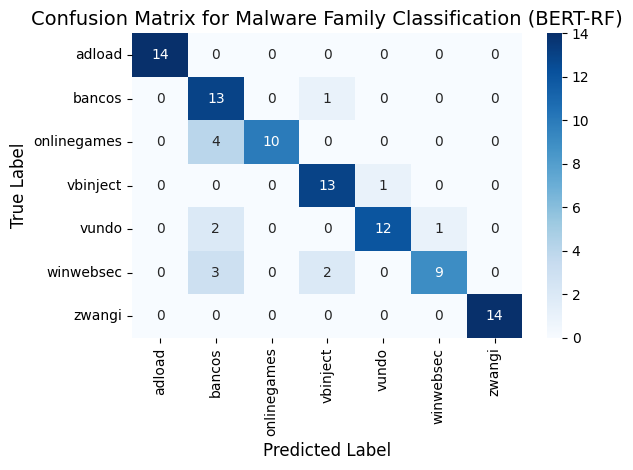

In [67]:
# Generate the confusion matrix
cm_rf_bert = confusion_matrix(y_test_bert, y_pred_rf_bert)
cm_rf_bert_df = pd.DataFrame(cm_rf_bert, index=label_encoder.classes_, columns=label_encoder.classes_)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_rf_bert_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (BERT-RF)', fontsize=14)

plt.tight_layout()

In [68]:
accuracies.append({
    'embedding': 'BERT',
    'classifier': 'Random Forest',
    'accuracy': round(accuracy_score(y_test_bert, y_pred_rf_bert), 2)
})

### 3.2 XGBoost (eXtreme Gradient Boosting)

#### 3.2.1 Word2Vec-XGBoost

In [69]:
# Train Word2Vec-XGBoost classifier
xgb_word2vec = XGBClassifier(objective='multi:softprob', num_class=len(malware_families), n_estimators=100, random_state=42)
xgb_word2vec.fit(X_train_word2vec, y_train_word2vec)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=7, ...)

In [70]:
# Make predictions
y_pred_xgb_word2vec = xgb_word2vec.predict(X_test_word2vec)
# Evaluate the model
print('Word2Vec + XGBoost Classifier:')
print(classification_report(y_test_word2vec, y_pred_xgb_word2vec, target_names=malware_families))

Word2Vec + XGBoost Classifier:
              precision    recall  f1-score   support

      adload       0.88      1.00      0.93        14
      bancos       0.92      0.79      0.85        14
 onlinegames       0.73      0.79      0.76        14
    vbinject       0.73      0.79      0.76        14
       vundo       0.88      0.93      0.90        15
   winwebsec       1.00      0.71      0.83        14
      zwangi       0.93      1.00      0.97        14

    accuracy                           0.86        99
   macro avg       0.87      0.86      0.86        99
weighted avg       0.87      0.86      0.86        99



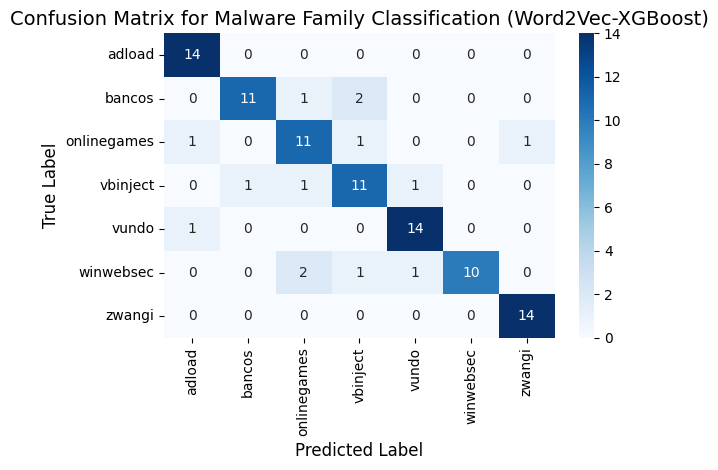

In [71]:
# Generate the confusion matrix
cm_xgb_word2vec = confusion_matrix(y_test_word2vec, y_pred_xgb_word2vec)
cm_xgb_word2vec_df = pd.DataFrame(cm_xgb_word2vec, index=label_encoder.classes_, columns=label_encoder.classes_)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_xgb_word2vec_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (Word2Vec-XGBoost)', fontsize=14)

plt.tight_layout()

In [72]:
accuracies.append({
    'embedding': 'Word2Vec',
    'classifier': 'XGBoost',
    'accuracy': round(accuracy_score(y_test_word2vec, y_pred_xgb_word2vec), 2)
})

#### 3.2.2 BERT-XGBoost

In [73]:
# Train BERT-XGBoost classifier
xgb_bert = XGBClassifier(objective='multi:softprob', num_class=len(malware_families), n_estimators=100, random_state=42)
xgb_bert.fit(X_train_bert, y_train_bert)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=7, ...)

In [74]:
# Make predictions
y_pred_xgb_bert = xgb_bert.predict(X_test_bert)
# Evaluate the model
print('BERT + XGBoost Classifier:')
print(classification_report(y_test_bert, y_pred_xgb_bert, target_names=malware_families))

BERT + XGBoost Classifier:
              precision    recall  f1-score   support

      adload       1.00      1.00      1.00        14
      bancos       0.57      0.93      0.70        14
 onlinegames       0.91      0.71      0.80        14
    vbinject       0.86      0.86      0.86        14
       vundo       0.93      0.87      0.90        15
   winwebsec       1.00      0.64      0.78        14
      zwangi       1.00      1.00      1.00        14

    accuracy                           0.86        99
   macro avg       0.89      0.86      0.86        99
weighted avg       0.89      0.86      0.86        99



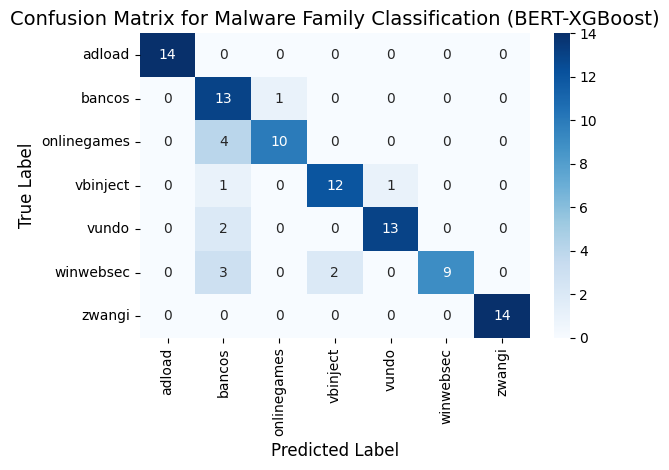

In [75]:
# Generate the confusion matrix
cm_xgb_bert = confusion_matrix(y_test_bert, y_pred_xgb_bert)
cm_xgb_bert_df = pd.DataFrame(cm_xgb_bert, index=label_encoder.classes_, columns=label_encoder.classes_)

# Create a heatmap from the confusion matrix
sns.heatmap(cm_xgb_bert_df, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Malware Family Classification (BERT-XGBoost)', fontsize=14)

plt.tight_layout()

In [76]:
accuracies.append({
    'embedding': 'BERT',
    'classifier': 'XGBoost',
    'accuracy': round(accuracy_score(y_test_bert, y_pred_xgb_bert), 2)
})

In [ ]:
# Save accuracies to Pickle file for later use
accuracies_df = pd.DataFrame(accuracies)
accuracies_df.to_pickle('accuracies.pkl')